## Homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.


## Loading the data

Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Loading the dataset:

In [2]:
df = pd.read_csv('../data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Missing values and log transformation:

In [3]:
df = df.fillna(0)

df['median_house_value'] = np.log1p(df['median_house_value'])

In order to create a DMatrix for the last question, we will also change the entries `<1H OCEAN` from the `ocean_proximity` column to `1H OCEAN`.

In [4]:
df.loc[df['ocean_proximity'] == '<1H OCEAN', 'ocean_proximity'] = '1H OCEAN'

Train/test split:

In [5]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

print("Size of full set: {}".format(len(df)))
print("Size of train set: {} -> {:0.1f} %".format(len(df_train), 100 * len(df_train) / len(df)))
print("Size of validation set: {} -> {:0.1f} %".format(len(df_val), 100 * len(df_val) / len(df)))
print("Size of test set: {} -> {:0.1f} %".format(len(df_test), 100 * len(df_test) / len(df)))

Size of full set: 20640
Size of train set: 12384 -> 60.0 %
Size of validation set: 4128 -> 20.0 %
Size of test set: 4128 -> 20.0 %


In [6]:
y_train = df_train['median_house_value']
y_val = df_val['median_house_value']

df_train.drop('median_house_value', axis=1, inplace=True)
df_val.drop('median_house_value', axis=1, inplace=True)

DictVectorizer:

In [7]:
from sklearn.feature_extraction import DictVectorizer

dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

- [X] `ocean_proximity=INLAND`
- [ ] `total_rooms`
- [ ] `latitude`
- [ ] `population`

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)

dt.fit(X_train, y_train)

tree_text = export_text(dt, feature_names=dv.feature_names_)

print(tree_text)

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

- [ ] 0.05
- [X] 0.25
- [ ] 0.55
- [ ] 0.85

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfr = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                            n_jobs=-1)

rfr.fit(X_train, y_train)

y_pred_train = rfr.predict(X_train)
y_pred_val = rfr.predict(X_val)

rfr_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("RMSE Train = {:0.2f}".format(rfr_score_train))
print("RMSE Validation = {:0.2f}".format(rfr_score_val))

RMSE Train = 0.11
RMSE Validation = 0.25


## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- [X] 10
- [ ] 55
- [ ] 75
- [ ] 150

In [10]:
rmse_scores = []
for n in np.arange(10, 210, 10):
    rfr = RandomForestRegressor(n_estimators=n,
                                random_state=1,
                                n_jobs=-1)

    rfr.fit(X_train, y_train)

    y_pred_val = rfr.predict(X_val)

    rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

    rmse_scores.append(rfr_score_val)
    print("RMSE {} = {:0.2f}".format(n, rfr_score_val))

RMSE 10 = 0.25
RMSE 20 = 0.24
RMSE 30 = 0.24
RMSE 40 = 0.23
RMSE 50 = 0.23
RMSE 60 = 0.23
RMSE 70 = 0.23
RMSE 80 = 0.23
RMSE 90 = 0.23
RMSE 100 = 0.23
RMSE 110 = 0.23
RMSE 120 = 0.23
RMSE 130 = 0.23
RMSE 140 = 0.23
RMSE 150 = 0.23
RMSE 160 = 0.23
RMSE 170 = 0.23
RMSE 180 = 0.23
RMSE 190 = 0.23
RMSE 200 = 0.23


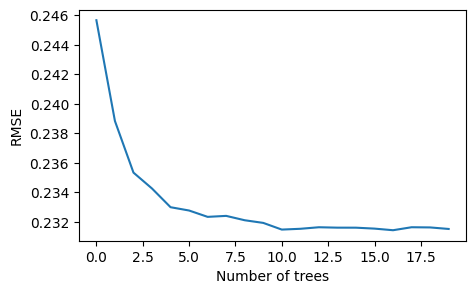

In [11]:
plt.figure(figsize=(5,3))
plt.plot(rmse_scores)
plt.ylabel('RMSE')
plt.xlabel('Number of trees')
plt.show()

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

- [ ] 10
- [ ] 15
- [ ] 20
- [X] 25

In [12]:
all_rmse = {} 
for max_depth in [10, 15, 20, 25]:
    rmse_scores = []
    for n in np.arange(10, 210, 10):
        rfr = RandomForestRegressor(n_estimators=n,
                                    random_state=1,
                                    max_depth=max_depth,
                                    n_jobs=-1)

        rfr.fit(X_train, y_train)

        y_pred_val = rfr.predict(X_val)

        rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

        rmse_scores.append(rfr_score_val)
        print("RMSE {} = {:0.2f}".format(n, rfr_score_val))

    all_rmse[max_depth] = rmse_scores

RMSE 10 = 0.25
RMSE 20 = 0.25
RMSE 30 = 0.25
RMSE 40 = 0.25
RMSE 50 = 0.25
RMSE 60 = 0.25
RMSE 70 = 0.25
RMSE 80 = 0.25
RMSE 90 = 0.25
RMSE 100 = 0.25
RMSE 110 = 0.25
RMSE 120 = 0.25
RMSE 130 = 0.25
RMSE 140 = 0.25
RMSE 150 = 0.25
RMSE 160 = 0.25
RMSE 170 = 0.25
RMSE 180 = 0.25
RMSE 190 = 0.25
RMSE 200 = 0.25
RMSE 10 = 0.25
RMSE 20 = 0.24
RMSE 30 = 0.24
RMSE 40 = 0.24
RMSE 50 = 0.23
RMSE 60 = 0.23
RMSE 70 = 0.23
RMSE 80 = 0.23
RMSE 90 = 0.23
RMSE 100 = 0.23
RMSE 110 = 0.23
RMSE 120 = 0.23
RMSE 130 = 0.23
RMSE 140 = 0.23
RMSE 150 = 0.23
RMSE 160 = 0.23
RMSE 170 = 0.23
RMSE 180 = 0.23
RMSE 190 = 0.23
RMSE 200 = 0.23
RMSE 10 = 0.25
RMSE 20 = 0.24
RMSE 30 = 0.24
RMSE 40 = 0.23
RMSE 50 = 0.23
RMSE 60 = 0.23
RMSE 70 = 0.23
RMSE 80 = 0.23
RMSE 90 = 0.23
RMSE 100 = 0.23
RMSE 110 = 0.23
RMSE 120 = 0.23
RMSE 130 = 0.23
RMSE 140 = 0.23
RMSE 150 = 0.23
RMSE 160 = 0.23
RMSE 170 = 0.23
RMSE 180 = 0.23
RMSE 190 = 0.23
RMSE 200 = 0.23
RMSE 10 = 0.25
RMSE 20 = 0.24
RMSE 30 = 0.24
RMSE 40 = 0.23
RMSE 50

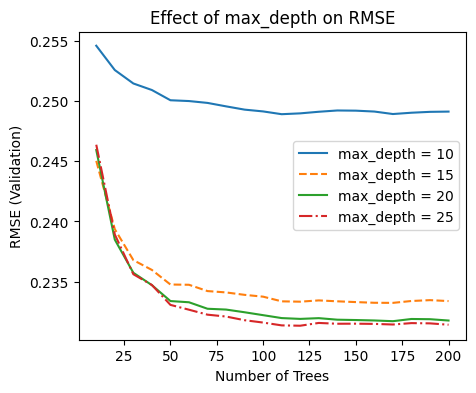

In [13]:
num_trees = np.arange(10, 210, 10)

plt.figure(figsize=(5, 4))
plt.plot(num_trees, all_rmse[10], '-', label='max_depth = 10')
plt.plot(num_trees, all_rmse[15], '--', label='max_depth = 15')
plt.plot(num_trees, all_rmse[20], '-', label='max_depth = 20')
plt.plot(num_trees, all_rmse[25], '-.', label='max_depth = 25')
plt.title('Effect of max_depth on RMSE')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE (Validation)')
plt.legend()
plt.show()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

- [ ] `total_rooms`
- [X] `median_income`	
- [ ] `total_bedrooms`
- [ ] `longitude`

In [14]:
rfr = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                            max_depth=20,
                            n_jobs=-1)

rfr.fit(X_train, y_train)

y_pred_val = rfr.predict(X_val)

rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

for feature, importance in zip(dv.feature_names_, rfr.feature_importances_):
    print(feature, np.round(importance, 3))

households 0.016
housing_median_age 0.033
latitude 0.101
longitude 0.096
median_income 0.363
ocean_proximity=1H OCEAN 0.002
ocean_proximity=INLAND 0.311
ocean_proximity=ISLAND 0.0
ocean_proximity=NEAR BAY 0.0
ocean_proximity=NEAR OCEAN 0.005
population 0.031
total_bedrooms 0.019
total_rooms 0.021


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` first to `0.1` and then to `0.01`

Which eta leads to the best RMSE score on the validation dataset?

- [X] 0.3
- [ ] 0.1
- [ ] Both gives same

In [15]:
import xgboost as xgb

# Creating a DMatrix for training and validation sets
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

# Watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [16]:
eta_scores = []
for eta in [0.01, 0.1, 0.3]:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    print("ETA:", eta)
    evals_result = {}
    model_xgb = xgb.train(xgb_params, 
                        dtrain,
                        num_boost_round=100,
                        evals=watchlist,
                        evals_result=evals_result, 
                        verbose_eval=10)
    eta_scores.append(evals_result['val']['rmse'])  

ETA: 0.01
[0]	train-rmse:11.48634	val-rmse:11.49225
[10]	train-rmse:10.38969	val-rmse:10.39532
[20]	train-rmse:9.39796	val-rmse:9.40346
[30]	train-rmse:8.50110	val-rmse:8.50645
[40]	train-rmse:7.69008	val-rmse:7.69524
[50]	train-rmse:6.95672	val-rmse:6.96171
[60]	train-rmse:6.29360	val-rmse:6.29841
[70]	train-rmse:5.69400	val-rmse:5.69854
[80]	train-rmse:5.15187	val-rmse:5.15621
[90]	train-rmse:4.66171	val-rmse:4.66589
[99]	train-rmse:4.26092	val-rmse:4.26496
ETA: 0.1
[0]	train-rmse:10.44372	val-rmse:10.44938
[10]	train-rmse:3.65741	val-rmse:3.66135
[20]	train-rmse:1.30499	val-rmse:1.31054
[30]	train-rmse:0.51144	val-rmse:0.52189
[40]	train-rmse:0.27984	val-rmse:0.30053
[50]	train-rmse:0.22614	val-rmse:0.25334
[60]	train-rmse:0.21035	val-rmse:0.24189
[70]	train-rmse:0.20116	val-rmse:0.23684
[80]	train-rmse:0.19384	val-rmse:0.23398
[90]	train-rmse:0.18794	val-rmse:0.23206
[99]	train-rmse:0.18329	val-rmse:0.23054
ETA: 0.3
[0]	train-rmse:8.12733	val-rmse:8.13245
[10]	train-rmse:0.34481	va

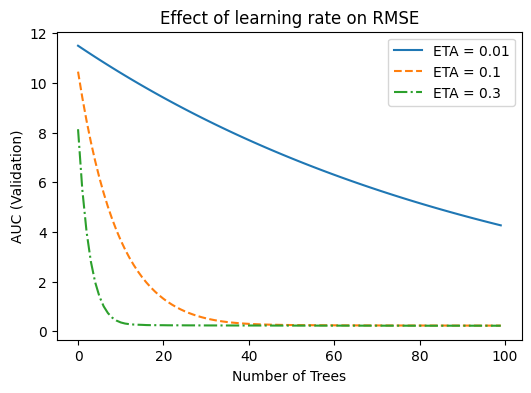

In [17]:
num_trees = range(len(eta_scores[0]))

plt.figure(figsize=(6, 4))
plt.plot(num_trees, eta_scores[0], '-', label='ETA = 0.01')
plt.plot(num_trees, eta_scores[1], '--', label='ETA = 0.1')
plt.plot(num_trees, eta_scores[2], '-.', label='ETA = 0.3')
plt.title('Effect of learning rate on RMSE')
plt.xlabel('Number of Trees')
plt.ylabel('AUC (Validation)')
plt.legend()
plt.show()